![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Plot an Ensemble of CMIP6 Climate Projections

This notebook provides a practical introduction on how to access and process [CMIP6 global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview) data available in the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/) of the [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/). The workflow shows how to compute and visualize the output of an ensemble of models for the annual global average temperature between 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` for the period from 2015 to 2100.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections) more about CMIP6 global climate projections and the CMIP6 experiments in the CDS.

<div class="alert alert-block alert-success">
    <b>NOTE</b>: </br>
    For the sake of simplicity, and to facilitate data download, the tutorial will make use of some of the coarser resolution models that have a smaller data size. It is nevertheless only a choice for this exercise and <b>not a recommendation</b> (since ideally all models, including those with highest resolution, should be used). Many more models are available on the CDS, and when calculating an ensemble of models, <b>it is best practice to use as many as possible for a more reliable output</b>. See <a href="https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models,gridsandpressurelevels">here </a> a full list of models included in the CDS-CMIP6 dataset.</div>

<hr>

## Learning objectives 🧠
  
1. Learn to compute a model ensemble and visualize its output.

<hr>

## Target audience 🎯

**Anyone** interested in learning how to predicting climate variables through the use of model ensembles.

<hr>

## Prerequisites and assumed knowledge 🔍
1. **Programming Skills**: Familiarity with programming concepts, particularly in Python, as the tutorial involves using loops, defining functions and using multiple different libraries for data manipulation and visualization.
   
2. **Familiarity with API Usage**: Understanding of how to use Application Programming Interfaces (APIs) will be useful for accessing data through the CDS API.

3. **Familiarity with multidimensional data structure**: Comprehending what are data dimensions and how they are organized in an array will be helpful.

4. **Familiarity with the concept of model ensembling**: check [this C3S module](https://learning.ecmwf.int/mod/scorm/player.php?a=170&currentorg=Ensemble_Forecasting_ORG&scoid=440) to learn more about model ensembles.

<hr>

:::{admonition} Difficulty
:class: tip
3/5
:::

<hr>

:::{dropdown} Run the tutorial
:open:
### WEKEO

[WEkEO](https://www.wekeo.eu/) serves as the official platform of the European Centre for Medium-Range Weather Forecasts (ECMWF), offering access to an extensive array of climate data and tools for analysis and visualization. It provides a robust environment for conducting in-depth analysis and exploration of climate-related datasets. To learn more about WEkEO and its offerings, visit their [website](https://www.wekeo.eu/).

[Run this notebook on WEKEO](https://www.wekeo.eu/) 

### Possible Cloud Services

While Kaggle, Binder, and Colab are popular options for running notebooks in the cloud, it's essential to note that these are just a few among many available choices. Each platform has its unique features and capabilities, catering to diverse user needs and preferences.



| **Kaggle** | **Binder** | **Colab** |
|:----------:|:---------:|:--------:|
| [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Randbee/projections-cmip6/blob/master/projections-cmip6.ipynb) | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Randbee/projections-cmip6/master?labpath=projections-cmip6.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Randbee/projections-cmip6/blob/master/projections-cmip6.ipynb) |
:::

<hr>


## Outline

1. Import the necessary libraries
2. Access data with the CDS API
3. Unzip the downloaded data files
4. Load and prepare CMIP6 data for one model and one experiment
    1. Load and inspect data
    2. Spatial aggregation
    3. Temporal aggregation
    4. Conversion from Keelvin to Celsius
    5. Creation of additional data dimensions
6. Load and prepare CMIP6 data for all models and experiments
7. Visualize CMIP6 annual global average temperature between 1850 to 2100
    1. Calculate quantiles for model ensemble
    2. View time-series

<hr>

## 1. Import the necessary libraries

For downloading the data from the CDS we will need [cdsapi](https://pypi.org/project/cdsapi/). We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular [xarray](https://docs.xarray.dev/en/stable/), and [pandas](https://pandas.pydata.org/) to work with dataframes. We will also need libraries for plotting and viewing data, in this case we will use [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/).
If you don't have any of the following libraries, you must install it. You can do it like this:

In [25]:
!pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


If you need to install dask, then you must **restart your Kernel** before continuing. For that, go the the `Kernel` tab above.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    Note the exclamation mark in the line of code above. This means the code will run as a shell (as opposed to a notebook) command.</div>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    If you are having trouble to work with the xarray library, check the C3S tutorial on climatologies for detailed help.</div>

In [1]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
import os
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import dask

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## 2. Access data with the CDS API

To access data from the CDS, you will need first to [register](https://cds.climate.copernicus.eu/#!/home) at the ADS registration page (if you haven't already done so), [log in](https://cds.climate.copernicus.eu/user/login), and accept the Terms and Conditions at the end of the `Download data` tab.<br>

To obtain data programmatically from the CDS, you will need an API Key that can be found in the [api-how-to page](https://cds.climate.copernicus.eu/api-how-to). Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS. Your API key is the entire string of characters that appears after `key:`

Now copy your API key into the code cell below, replacing `#######` with your key.

In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [3]:
DATADIR = './'

The next step is then to request the data with the help of the CDS API. Below, we loop through multiple data requests. These include data for different models and scenarios. It is not possible to specify multiple models in one data request as their spatial resolution varies.

We will download monthly aggregated data. These are disseminated as netcdf files within a zip archive.

In order to loop through the various experiments and models in our data requests, we will specify them as Python 'lists' here:

In [23]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [24]:
models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

<div class="alert alert-block alert-success">
    <b>NOTE</b>: </br>
    Note that these are a selection of the lightest models (in terms of data volume), to facilitate download for the sake of this exercise. There are many <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview">more models available on the CDS</a>.</div>

Now we can download the data for each model and experiment sequentially. We will do this separately for the historical experiments and for the various future scenarios, given that they refer to two different time periods.
In the `Download data` tab, we will select the following parameters to download:

- **Data**: `CMIP6 global climate projections of near-surface air temperature`<br>
- **Experiments**: `Historical`, `SSP1-2.6`, `SSP2-4.5`, `SSP5-8.5` <br>
- **Models**: 7 models from Germany, France, UK, Japan and Russia represented in the `models` list <br>
- **Temporal range**: Historical: `1850 - 2014`. Scenarios: `2015 - 2100` <br>
- **Spatial coverage**: `Global` <br>
- **Format**: `NetCDF`, compressed into zip files

And this is the time when you must accept the Terms and Conditions that are at the bottom of this page.

In [7]:
# DOWNLOAD DATA FOR HISTORICAL PERIOD

c = cdsapi.Client(url=URL, key=KEY)

for j in models:
    c.retrieve(
        'projections-cmip6',
        {
            'format': 'zip',
            'temporal_resolution': 'monthly',
            'experiment': 'historical',
            'level': 'single_levels',
            'variable': 'near_surface_air_temperature',
            'model': f'{j}',
            'date': '1850-01-01/2014-12-31',
        },
        f'{DATADIR}cmip6_monthly_1850-2014_historical_{j}.zip')

2024-06-27 11:14:26,491 INFO Welcome to the CDS
2024-06-27 11:14:26,492 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-06-27 11:14:26,702 INFO Request is queued
2024-06-27 11:14:27,758 INFO Request is running
2024-06-27 11:14:40,168 INFO Request is completed
2024-06-27 11:14:40,169 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data8/adaptor.esgf_wps.retrieve-1719479674.075813-9693-6-cdc6b06e-2328-4f58-943a-996154993c91.zip to ./cmip6_monthly_1850-2014_historical_hadgem3_gc31_ll.zip (114.1M)
2024-06-27 11:15:03,120 INFO Download rate 5M/s                                 
2024-06-27 11:15:03,220 INFO Welcome to the CDS
2024-06-27 11:15:03,222 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-06-27 11:15:03,457 INFO Request is queued
2024-06-27 11:15:04,514 INFO Request is running
2024-06-27 11:15:16,922 INFO Request is completed
2024-06-27 11:15

In [8]:
# DOWNLOAD DATA FOR FUTURE SCENARIOS

c = cdsapi.Client(url=URL, key=KEY)

for i in experiments[1:]:
    for j in models:
        c.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': f'{i}',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{j}',
                'date': '2015-01-01/2100-12-31',
            },
            f'{DATADIR}cmip6_monthly_2015-2100_{i}_{j}.zip')

2024-06-27 11:20:00,085 INFO Welcome to the CDS
2024-06-27 11:20:00,087 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-06-27 11:20:00,333 INFO Request is queued
2024-06-27 11:20:01,383 INFO Request is running
2024-06-27 11:20:13,781 INFO Request is completed
2024-06-27 11:20:13,783 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.esgf_wps.retrieve-1719480004.7341053-31229-17-13ab3c16-cb97-43ee-aee3-ffd20a5afb17.zip to ./cmip6_monthly_2015-2100_ssp126_hadgem3_gc31_ll.zip (55.4M)
2024-06-27 11:20:26,611 INFO Download rate 4.3M/s                               
2024-06-27 11:20:26,699 INFO Welcome to the CDS
2024-06-27 11:20:26,700 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2024-06-27 11:20:26,837 INFO Request is queued
2024-06-27 11:20:27,889 INFO Request is running
2024-06-27 11:20:35,174 INFO Request is completed
2024-06-27 11:20:3

<hr>

## 3. Unzip the downloaded data files

From the CDS, CMIP6 data are available as `NetCDF` files compressed into `zip` archives. For this reason, before we can load any data, we have to extract the files. Having downloaded the four experiments `historical`, `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` as seperate zip files, we can use the functions from the `zipfile` Python package to extract their contents. For each zip file we first construct a `ZipFile()` object, then we apply the function `extractall()` to extract its content.

In [4]:
cmip6_zip_paths = glob(f'{DATADIR}*.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

### Create a list of the extracted files

To facilitate batch processing later in the tutorial, here we create a list of the extracted NetCDF files:

In [5]:
cmip6_nc = list()
cmip6_nc_rel = glob(f'{DATADIR}tas*.nc')
for i in cmip6_nc_rel:
    cmip6_nc.append(os.path.basename(i))

We will briefly inspect this list by printing the first five elements, corresponding to the filenames of a sample of the extracted NetCDF files:

In [6]:
cmip6_nc[0:5]

['tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012_v20190507.nc',
 'tas_Amon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_205501-207412_v20190710.nc',
 'tas_Amon_UKESM1-0-LL_historical_r13i1p1f2_gn_185001-194912_v20190406.nc',
 'tas_Amon_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_207501-209412_v20190710.nc',
 'tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912_v20190507.nc']

<hr>

## 4. Load and prepare CMIP6 data for one model and one experiment

Now that we have downloaded and extracted the data, we can prepare it in order to view a time series of the spread of annual global temperature for the model ensemble. These preparation steps include the following:

1. **Spatial aggregation**: to have a single global temperature value for each model/experiment dataset, and for each time step
2. **Temporal aggregation**: from monthly to yearly
3. **Conversion from Kelvin to Celsius**
4. **Creation of additional data dimensions** in preparation for the merging of datasets from different models and experiments

In this section we apply these steps to a single dataset from one model and one experiment. In the next section we merge data from all models/experiments in preparation for the final processing and plotting of the temperature time series.

<hr>

### 4.A. Load and inspect data

We begin by loading the first of the NetCDF files in our list. We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read NetCDF files.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `lat`, `lon`, `time`, of which the dimension `bnds` is not callable.

In [7]:
ds = xr.open_dataset(f'{DATADIR}{cmip6_nc[0]}')
ds

<xarray.Dataset> Size: 68MB
Dimensions:    (time: 612, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 5kB 2050-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 10kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 68MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2019-04-18T14:30:46Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/542545ca-f8aa-49bf-abf5-b6b0e97dbaec

By examining the data above, we can see from the temporal range (1850 to 2014) that it is from the `historical` experiment.

We see that the data dimensions have been given labelled coordinates of time, latitude and longitude. We can find more about the dataset from the `Attributes`, such information includes the model name, description of the variable (`long_name`), units, etc.

Some of this information we will need later, this includes the experiment and model IDs. We will save these into variables:

In [8]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

An `xarray.Dataset()` may contain arrays of multiple variables. We only have one variable in the dataset, which is near-surface air temperature, `tas`. Below we create an `xarray.DataArray()` object, which takes only one variable, but gives us more flexibility in processing.

In [9]:
da = ds['tas']

<hr>

### 4.B. Spatial aggregation

The next step is to aggregate the temperature values spatially (i.e. average over the latitude and longitude dimensions) and compute the global monthly near-surface temperature.

A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes. 

This can be implemented by first calculating weights as a function of the cosine of the latitude, then applying these weights to the data array with the xarray function `weighted()`:

In [10]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

The next step is then to compute the mean across the latitude and longitude dimensions of the weighted data array with the function `mean()`. The result is a DataArray with one dimension (`time`).

In [11]:
da_agg = da_weighted.mean(['lat', 'lon'])

<hr>

### 4.C. Temporal aggregation

We now aggregate the monthly global near-surface air temperature values to annual global near-surface air temperature values. This operation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, we can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray. Please note that this operation changes the name of the dimension from `time` to `year`.

In [12]:
da_yr = da_agg.groupby('time.year').mean()

<hr>

### 4.D. Conversion from Kelvin to Celsius

The metadata of the original data (before it was stripped during the subsequent processing steps) tells us that the near-surface air temperature data values are in units of Kelvin. We will convert them to degrees Celsius by subtracting 273.15 from the data values. 

In [13]:
da_yr = da_yr - 273.15

<hr>

### 4.E. Create additional data dimensions

Finally, we will create additional dimensions for the model and for the experiment. These we will label with the model and experiment name as taken from the metadata of the original data (see above). These will be useful when we repeat the processes above for all models and experiments, and combine them into one array.

In [14]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

<hr>

## 5. Load and prepare CMIP6 data for all models and experiments

To repeat the steps above for all models and all experiments, we will collect all of the commands we have used so far into a function, which we can then apply to a batch of files corresponding to the data from all models and experiments.

In [15]:
# Function to aggregate in geographical lat lon dimensions

def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

Now we can apply this function to all the extracted NetCDF files. The `try` and `except` clauses ensure that all NetCDF files are attempted, even if some fail to be processed. One reason why some may fail is if the data are labelled differently, e.g. the model *MCM-UA-1-0* has coordinates labelled as "*latitude*" and *longitude*". This differs from the suggested standard, and more commonly applied labels of "*lat*" and "*lon*". Any that fail will be recorded in a print statement, and these can be processed separately. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-QualitycontroloftheCDS-CMIP6subset) more details on the quality control of the CMIP6 datasets on the CDS.

In [16]:
for i in cmip6_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

In the absence of any print statements, we see that all files were successfully processed. 

We will now combine these processed files into one dataset for the final steps to create a visualisation of near-surface air temperature from the model ensemble.

If all files have the same coordinates, the function `xarray.open_mfdataset` will merge the data according to the same coordinates.

In [17]:
data_ds = xr.open_mfdataset(f'{DATADIR}cmip6_agg*.nc')

The dataset created by `xarray.open_mfdataset` is by default in the form of `lazy Dask arrays`. 

Dask divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory. As opposed to eager evaluation, operations on Dask arrays are lazy, i.e. operations queue up a series of tasks mapped over blocks, and no computation is performed until you request values to be computed. See [this page](https://xarray.pydata.org/en/stable/user-guide/dask.html) for more details. 

To facilitate further processing we would need to convert these Dask arrays into in-memory "eager" arrays, which we can do by using the `load()` method: 

In [18]:
data_ds.load()

<xarray.Dataset> Size: 59kB
Dimensions:     (experiment: 4, model: 7, year: 251)
Coordinates:
  * year        (year) int64 2kB 1850 1851 1852 1853 ... 2097 2098 2099 2100
  * model       (model) <U15 420B 'HadGEM3-GC31-LL' ... 'UKESM1-0-LL'
  * experiment  (experiment) <U10 160B 'historical' 'ssp126' 'ssp245' 'ssp585'
    height      (model) float64 56B 1.5 2.0 2.0 2.0 2.0 2.0 1.5
Data variables:
    tas         (experiment, model, year) float64 56kB 13.58 13.62 ... 20.63

Finally, we create an Xarray DataArray object for the near-surface air temperature variable, 'tas':

In [19]:
data = data_ds['tas']

<hr>

## 6. Visualize the CMIP6 annual global average temperature between 1850 to 2100

We will now create a plot of the model ensemble of near-surface air temperature for the historical and future periods, according to the three selected scenarios.

### 6.A. Calculate quantiles for model ensemble

Rather than plotting the data from all models, we will instead view the range of values as given by quantiles, including the 10th (near to lower limit), the 50th (mid-range) and the 90th (near to upper limit) quantiles:

In [20]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The warning message is due to the presence of NaN (Not a Number) data given that the historical and scenario datasets represent only parts (historical and future respectively) of the entire time series. As these two datasets have been merged, NaN values will exist (e.g. there will be no data for the historical experiment for the future period).</div>

<hr>

### 6.B. View time-series

Finally we will visualise this data in one time-series plot. We will use the matplotlib function `plot()`. The dimension `year` will be the x-axis and the near-surface air temperature values in degrees Celsius will be the y-axis. 

The plotting function below has four main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.subplots()`
* **Plot the time-series**: plot the data for each experiment, including the historical experiment and three scenarios with the `plot()` function
* **Set axes limits, labels, title and legend**: Define title and axes labels, and add additional items to the plot, such as legend or gridlines
* **Save the figure**: Save the figure as a PNG file with the `matplotlib.pyplot.savefig()` function

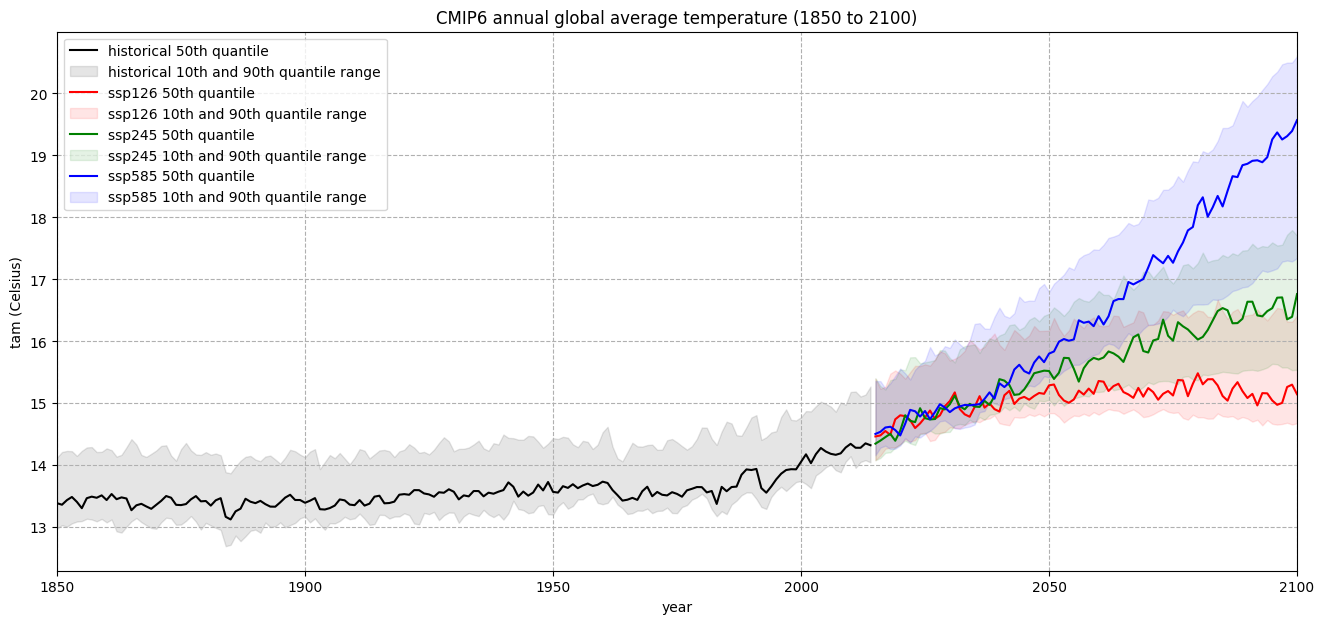

In [28]:
# Initiate the plot:
fig, ax = plt.subplots(1, 1, figsize = (16, 7))

#Plot the time-series:
colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

# Set axes limits, labels, title and legend:
ax.set_xlim(1850,2100)
ax.set_title('CMIP6 annual global average temperature (1850 to 2100)')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

#Save the figure:
fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

The visualization of the `CMIP6 annual global average temperature (1850 to 2100)` above shows that the global average temperature was more or less stable in the pre-industrial phase, but steadily increases since the 1990s. It shows further that, depending on the SSP scenario, the course and increase of the global annual temperature differs. While for the best case `SSP1-2.6` scenario, the global annual temperature could stabilize around 15 degC, in the worst case `SSP5-8.5` scenario, the global annual temperature could increase to above 20 degC.

<hr>

## Key Messages to Take Home 📌

- When calculating an ensemble of models, it is best practice to use as many as possible for a more reliable output.

- Before using the ensemble of models, preparation steps include spatial and temporal aggregation of data and possible conversion of units of measure.

- To merge datasets from different models and experiments, additional data dimensions must be created specifying the model and experiment of each dataset.

- Using quantiles instead of ploting all values eases data visualization.

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>